In [1]:
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import datacube
from pyproj import Proj, transform
from datacube.storage.masking import mask_invalid_data


Latitude = -35.092527   # degrees - Centre  latitude of field site
Longitude = 149.462373  # degrees - Centre longitude of field site
Platform = 'Sentinel2a' # Satellite name

SiteX = 100 # metres
SiteY = 100 # metres

DroneSpeed = 4      # m/s
TurnAroundTime = 2  # seconds
FoV = 7             # degrees
Height = 30         # metres

if Platform == 'Landsat8':
    PixelSize = 25.0 # metres
else:
    PixelSize = 10.0 # metres
    

FootPrint = 2 * Height * np.tan(np.deg2rad(FoV/2))
LineTime = round(SiteY/DroneSpeed, 1)

print("Footprint diameter:", round(FootPrint, 3), "metres")

print("Image to be taken every", round(FootPrint/DroneSpeed, 3), "seconds")

print("Fully sampled coverage will require", int(2*SiteY/FootPrint), "lines, with", 
      int(2*SiteX/FootPrint), "footprints per line")

print("Each line will take", LineTime, "seconds to complete")

print("The full field will take", datetime.timedelta(seconds=int(2 * (SiteX/FootPrint) * (LineTime+TurnAroundTime))), "h:mm:ss")

Footprint diameter: 3.67 metres
Image to be taken every 0.917 seconds
Fully sampled coverage will require 54 lines, with 54 footprints per line
Each line will take 25.0 seconds to complete
The full field will take 0:24:31 h:mm:ss


In [2]:
#
# Project Longitude, Latitude coordinates into Australia Albers
#
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
x1,y1 = Longitude, Latitude
OzAlbLon, OzAlbLat = transform(inProj,outProj,x1,y1)

In [3]:
dc = datacube.Datacube()

met_latdeg = (PixelSize) / (2*111319.9)
met_londeg = met_latdeg / math.cos(math.radians(Latitude))

SiteY_deg = SiteY / (2*111319.9)
SiteX_deg = SiteX / (2*111319.9*math.cos(math.radians(Latitude)))

query = {
         'time': (datetime.datetime.now() - datetime.timedelta(days=50), datetime.datetime.now()),
         'lat': (Latitude - SiteY_deg - met_latdeg, Latitude + SiteY_deg + met_latdeg),
         'lon': (Longitude - SiteX_deg - met_londeg, Longitude + SiteX_deg + met_latdeg),
         'output_crs': 'EPSG:3577',
         'resampling': 'bilinear',
         'resolution': (-PixelSize, PixelSize)
        }

if Platform == 'Landsat8':
    sat_array = dc.load(product='ls8_nbart_scene', measurements=['red', 'green', 'blue'], **query)
elif Platform == 'Sentinel2a':
    sat_array = dc.load(product='s2a_ard_granule', measurements=['nbart_red', 'nbart_green', 'nbart_blue'], **query)
else:
    sat_array = dc.load(product='s2b_ard_granule', measurements=['nbart_red', 'nbart_green', 'nbart_blue'], **query)

sat_array = sat_array.sel(time=datetime.datetime.now(), method='nearest')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)


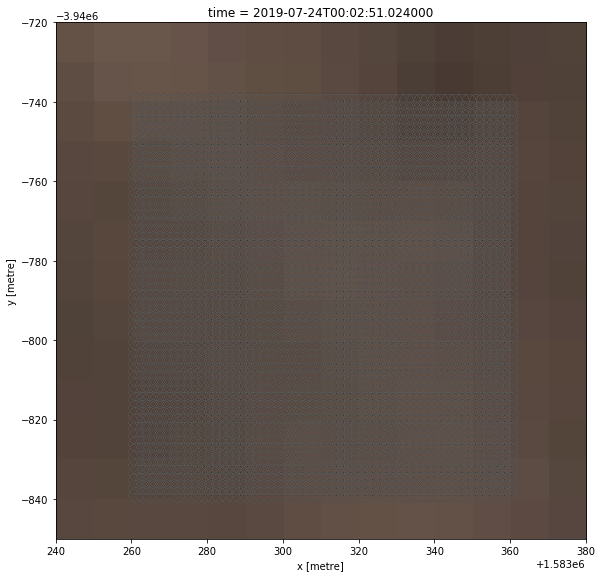

In [9]:

data = mask_invalid_data(sat_array)

fake_saturation = 5000
rgb = data.to_array(dim='color')
rgb = rgb.transpose(*(rgb.dims[1:]+rgb.dims[:1]))  # make 'color' the last dimension
rgb = rgb.where((rgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
rgb /= fake_saturation  # scale to [0, 1] range for imshow

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 9.5))
rgb.plot.imshow(x=data.crs.dimensions[1], y=data.crs.dimensions[0])

for i in np.arange(OzAlbLat - (SiteY/2), OzAlbLat + (SiteY/2), FootPrint/2):
    for j in np.arange(OzAlbLon - (SiteX/2), OzAlbLon + (SiteX/2), FootPrint/2):
        circle2 = plt.Circle((j, i), FootPrint/2, color='k', linewidth=0.5, fill=None)
        circle1 = plt.Circle((j, i), FootPrint/2, color='w', linewidth=0.2, fill=None)
        axes.add_artist(circle2)
        axes.add_artist(circle1)


In [10]:
bigquery = {
         'time': (datetime.datetime.now() - datetime.timedelta(days=50), datetime.datetime.now()),
         'lat': (Latitude - SiteY_deg - met_latdeg -0.01, Latitude + SiteY_deg + met_latdeg+0.01),
         'lon': (Longitude - SiteX_deg - met_londeg-0.01, Longitude + SiteX_deg + met_latdeg+0.01),
         'output_crs': 'EPSG:3577',
         'resampling': 'bilinear',
         'resolution': (-PixelSize, PixelSize)
        }

if Platform == 'Landsat8':
    bigsat_array = dc.load(product='ls8_nbart_scene', measurements=['red', 'green', 'blue'], **bigquery)
elif Platform == 'Sentinel2a':
    bigsat_array = dc.load(product='s2a_ard_granule', measurements=['nbart_red', 'nbart_green', 'nbart_blue'], **bigquery)
else:
    bigsat_array = dc.load(product='s2b_ard_granule', measurements=['nbart_red', 'nbart_green', 'nbart_blue'], **bigquery)

bigsat_array = bigsat_array.sel(time=datetime.datetime.now(), method='nearest')

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)


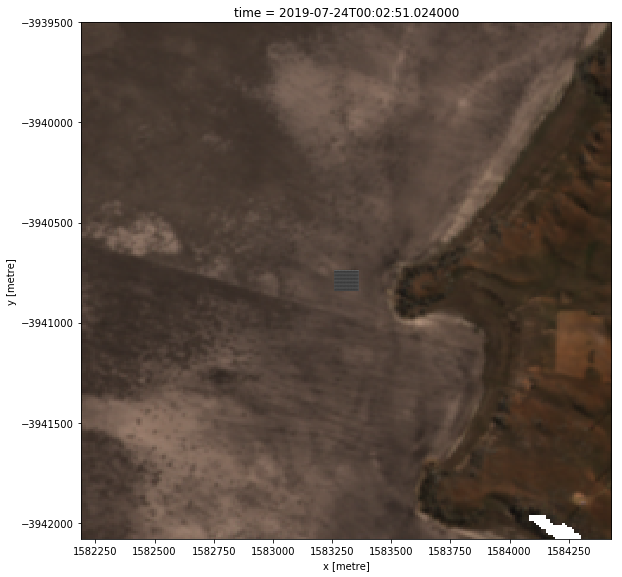

In [11]:
bigdata = mask_invalid_data(bigsat_array)

bigrgb = bigdata.to_array(dim='color')
bigrgb = bigrgb.transpose(*(bigrgb.dims[1:]+bigrgb.dims[:1]))  # make 'color' the last dimension
bigrgb = bigrgb.where((bigrgb <= fake_saturation).all(dim='color'))  # mask out pixels where any band is 'saturated'
bigrgb /= fake_saturation  # scale to [0, 1] range for imshow

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9.5, 9.5))
bigrgb.plot.imshow(x=bigdata.crs.dimensions[1], y=bigdata.crs.dimensions[0])

for i in np.arange(OzAlbLat - (SiteY/2), OzAlbLat + (SiteY/2), FootPrint/2):
    for j in np.arange(OzAlbLon - (SiteX/2), OzAlbLon + (SiteX/2), FootPrint/2):
        circle2 = plt.Circle((j, i), FootPrint/2, color='k', linewidth=0.5, fill=None)
        circle1 = plt.Circle((j, i), FootPrint/2, color='w', linewidth=0.2, fill=None)
        axes.add_artist(circle2)
        axes.add_artist(circle1)
